In [83]:

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.__version__)


2.9.1


In [84]:
dataset_dir = os.path.join(os.getcwd(), 'chest_xray')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_normal_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'NORMAL')))
dataset_train_pneumonia_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'PNEUMONIA')))

dataset_test_dir = os.path.join(dataset_dir, 'test')
dataset_test_normal_len = len(os.listdir(
    os.path.join(dataset_test_dir, 'NORMAL')))
dataset_test_pneumonia_len = len(os.listdir(
    os.path.join(dataset_test_dir, 'PNEUMONIA')))

dataset_val_dir = os.path.join(dataset_dir, 'val')
dataset_val_normal_len = len(os.listdir(
    os.path.join(dataset_val_dir, 'NORMAL')))
dataset_val_pneumonia_len = len(os.listdir(
    os.path.join(dataset_val_dir, 'PNEUMONIA')))

In [85]:
print('Training Normal: %s' % dataset_train_normal_len)
print('Training Pneumonia: %s' % dataset_train_pneumonia_len)
print('Test Normal: %s' % dataset_test_normal_len)
print('Test Pneumonia: %s' % dataset_test_pneumonia_len)
print('Validation Normal: %s' % dataset_val_normal_len)
print('Validation Pneumonia: %s' % dataset_val_pneumonia_len)

Training Normal: 1342
Training Pneumonia: 3876
Test Normal: 234
Test Pneumonia: 390
Validation Normal: 17
Validation Pneumonia: 18


In [86]:
image_width = 300
image_height = 300

image_color_channel = 1
image_color_channel_size = 3
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel, )


batch_size = 32
epochs = 20
learning_rate = 0.001

class_names = ['normal', 'pneumonia']

In [87]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)

Found 5216 files belonging to 2 classes.


In [88]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_val_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 33 files belonging to 2 classes.


In [89]:
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_test_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 624 files belonging to 2 classes.


In [90]:
# resize the images to a common size
def preprocess_image(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    
    # greyscale the image
    image = tf.image.rgb_to_grayscale(image)
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label
  
dataset_train = dataset_train.map(preprocess_image)
dataset_test = dataset_test.map(preprocess_image)
dataset_validation = dataset_validation.map(preprocess_image)



In [91]:
 
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

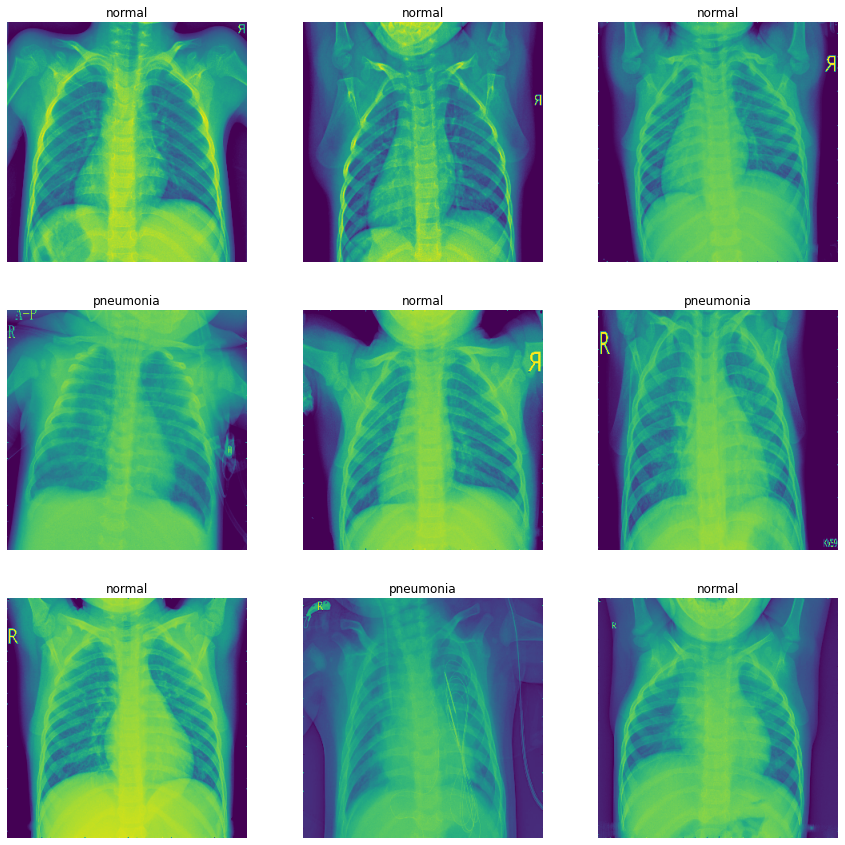

In [92]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

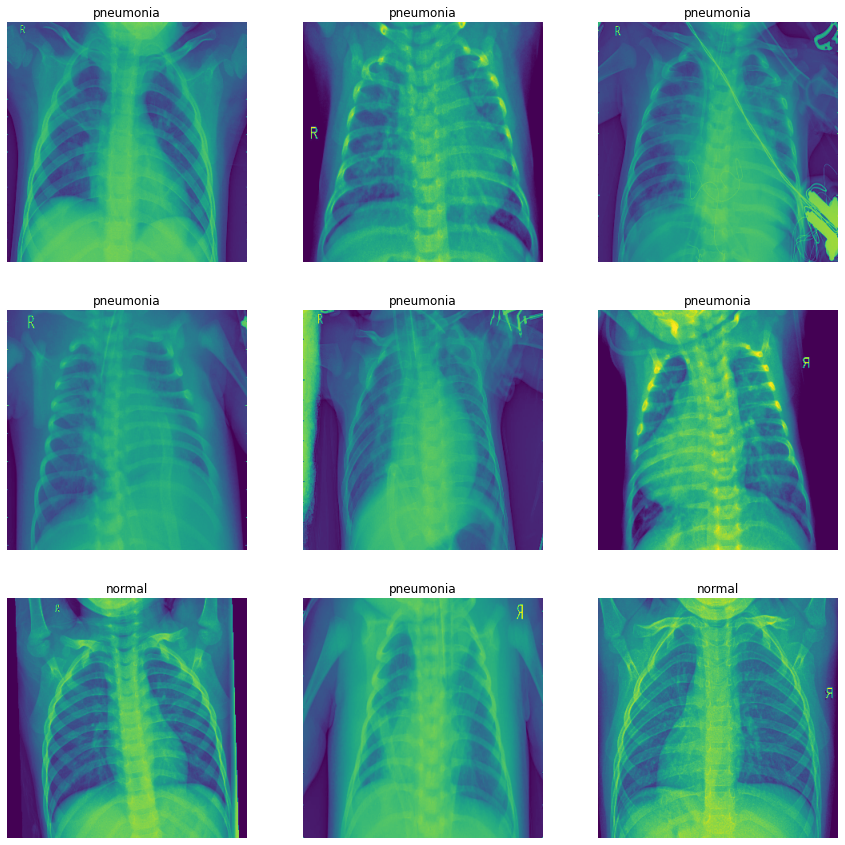

In [93]:
plot_dataset(dataset_test)

<Figure size 432x288 with 0 Axes>

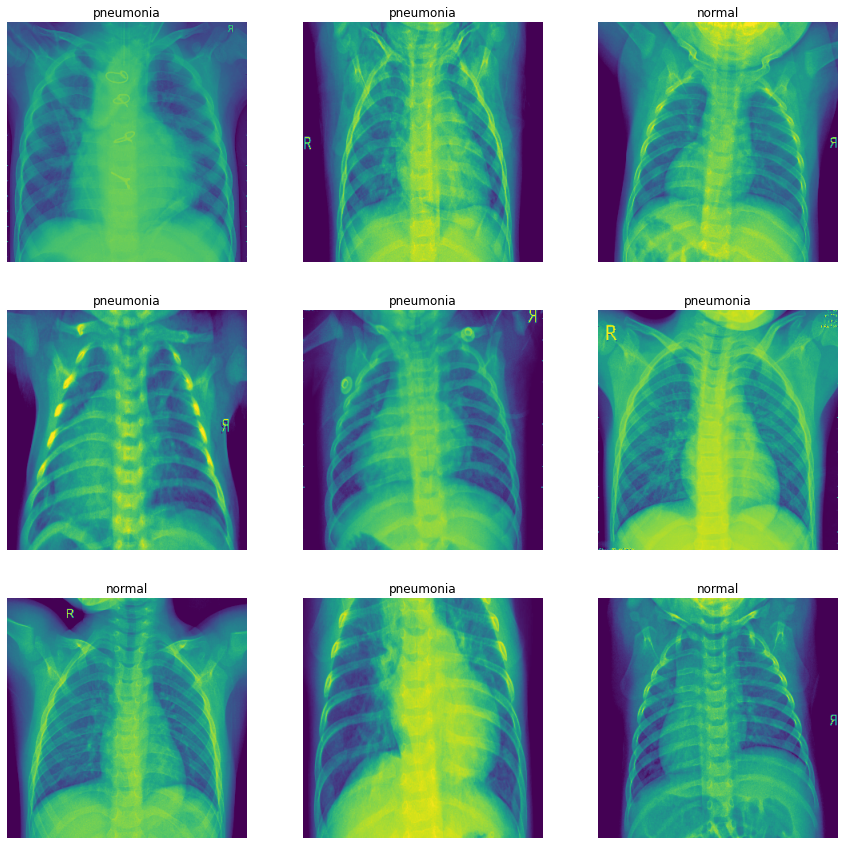

In [94]:
plot_dataset(dataset_train)

In [95]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [96]:
def plot_dataset_data_augmentation(dataset):
  plt.gcf().clear()
  plt.figure(figsize=(15, 15))
  
  for features, _ in dataset.take(1):
    feature = features[0]
    
    for i in range(9):
      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
      
      plt.subplot(3, 3, i + 1)
      plt.axis('off')
      
      plt.imshow(feature_data_augmentation[0]  / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

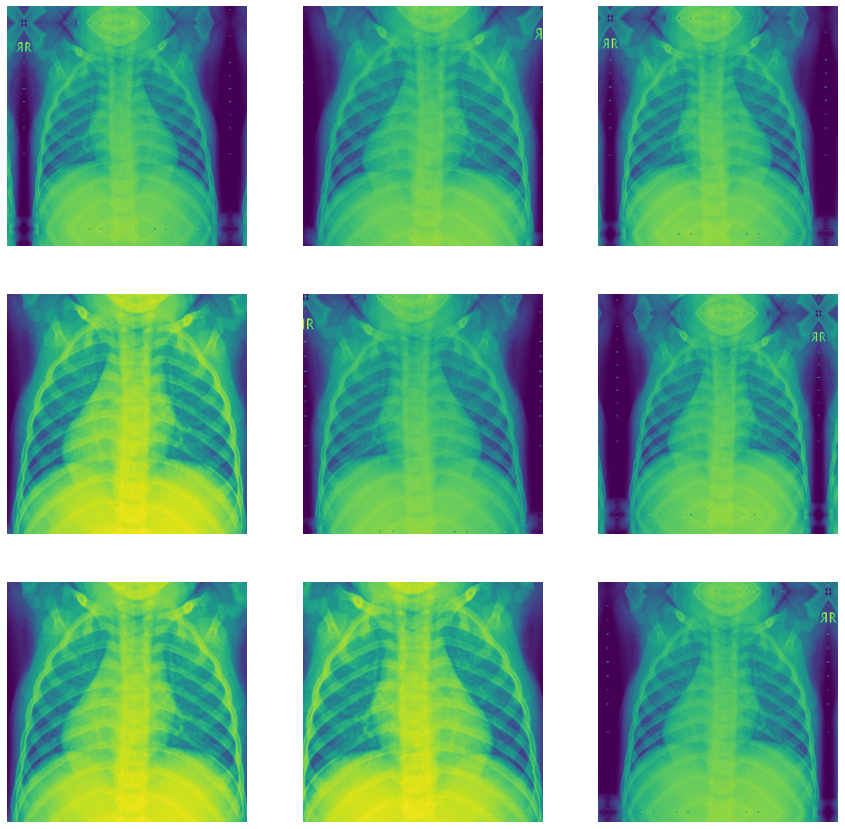

In [97]:
plot_dataset_data_augmentation(dataset_train)

In [98]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size,
        input_shape=image_shape
    ),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [99]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 300, 300, 1)       0         
                                                                 
 sequential_8 (Sequential)   (None, 300, 300, 1)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 300, 300, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                 

In [100]:
history = model.fit(
  dataset_train,
  validation_data=dataset_validation,
  epochs=epochs,
)

Epoch 1/20
163/163 [==============================] - 35s 197ms/step - loss: 3.1911 - accuracy: 0.8461 - val_loss: 0.4829 - val_accuracy: 0.7879
Epoch 2/20
163/163 [==============================] - 32s 191ms/step - loss: 0.1755 - accuracy: 0.9360 - val_loss: 0.2781 - val_accuracy: 0.9091
Epoch 3/20
163/163 [==============================] - 32s 190ms/step - loss: 0.1595 - accuracy: 0.9394 - val_loss: 0.4375 - val_accuracy: 0.8485
Epoch 4/20
163/163 [==============================] - 30s 182ms/step - loss: 0.1564 - accuracy: 0.9369 - val_loss: 0.5211 - val_accuracy: 0.8182
Epoch 5/20
163/163 [==============================] - 31s 188ms/step - loss: 0.1561 - accuracy: 0.9413 - val_loss: 0.2840 - val_accuracy: 0.8485
Epoch 6/20
163/163 [==============================] - 31s 189ms/step - loss: 0.2028 - accuracy: 0.9222 - val_loss: 0.4401 - val_accuracy: 0.8485
Epoch 7/20
163/163 [==============================] - 31s 189ms/step - loss: 0.1181 - accuracy: 0.9542 - val_loss: 0.4043 - val_ac

In [101]:
def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs_range = range(epochs)
  
  plt.gcf().clear()
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(1,2,2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  
  plt.show()

<Figure size 432x288 with 0 Axes>

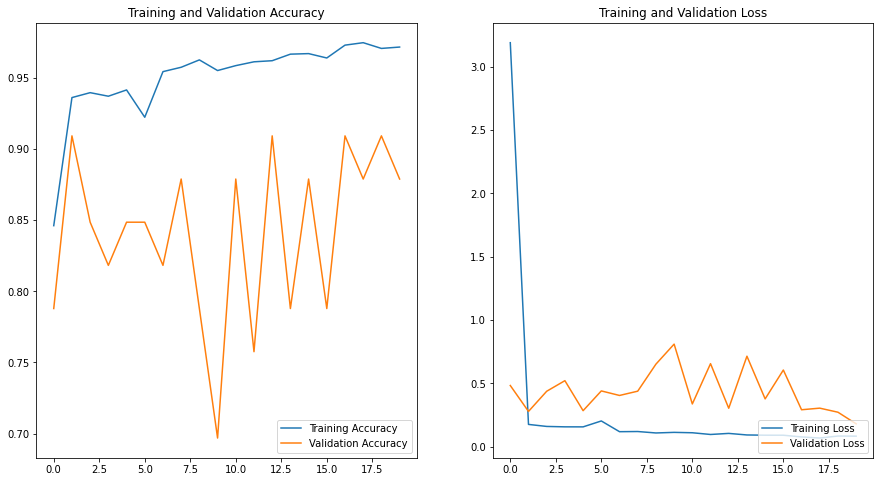

In [102]:
plot_model()

In [103]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if(predicted_label == true_label):
        color = 'white'
    else:
        color = 'red'

    plt.title("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color)


def plot_results(predictions, labels, images):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    # len of test_images
    len = predictions.shape[0]

    # random 25 different images
    arrayindex = random.sample(range(len), 25)

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plot_image(arrayindex[i], predictions[arrayindex[i]], labels, images)
        

        


1/1 [==============================] - 0s 21ms/step


<Figure size 432x288 with 0 Axes>

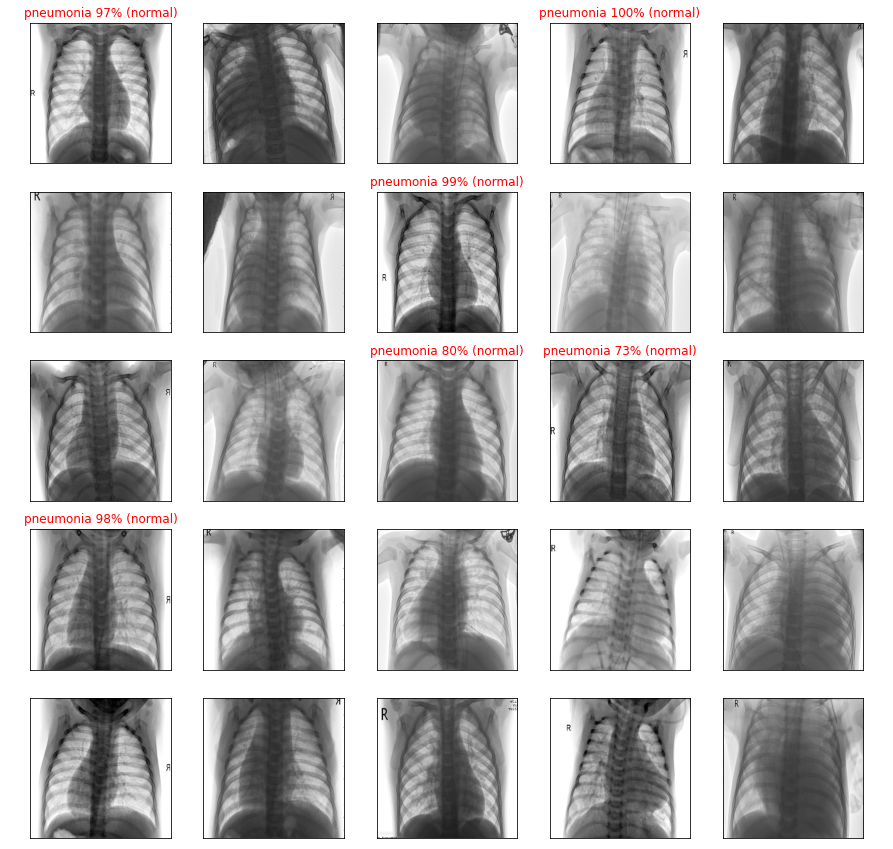

In [109]:
features, labels = dataset_test.as_numpy_iterator().next()
predictions = model.predict(features)

plot_results(predictions, labels, features)

In [105]:
# model.save('models/x_ray_v2.h5')

In [106]:
# model = tf.keras.models.load_model('models/x_ray_v1.h5')